# 0.0 Table of Contents

1. [Introduction](#1.0-Introduction)

2. [Feature Analysis](#2.0-Feature-Analysis)

# 1.0 Introduction
 

### 1.1 Project -  Binary classification of bitcoin addresses

-  **GOAL:** to predict whether an address has been the recipient of ransomware coins. 

-  **DATA:**  Data is time series (24hr chunks) derived from the topological and geometrical properties of the bitcoin network.

### 1.2 Basics

- Ransomware is a rogue compute code that encrypts the victim's filesystem unless money is paid to the attacker for decryption. 

- Bitcoin is often used for these payments because it provides a semi-anonymous transaction method.  

- The dataset was taken from the UCI Machine Learning Repository. It contains labelled data of addresses according to whether they have been involved in Ransomware. The data is from 2009 January to 2018 December. 
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

### 1.2.0 Breakdown

---
**"starter transactions"**: transactions which are spent outputs from the  previous time window <n>

Features:

- The **address** is a public BC address which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC).
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses.
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from a starter
transaction and ending at address $a$. Count captures
information about the number of transactions, whereas weight
 gives information about the amount of coins.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain). 
    
       
<n>
Engineered/derived features:
    
- bc_income = boxcox of income
    
- bc_length = boxcox of length
    
- yeo_weight = yeo of weight
   
- logbc_n_address = boxcox log of address

- bc_neighbors = box of neighbors
   
- sig_looped = sigmoid of looped
    
- log_count = log of count
   
- day_of_week = {'Monday':0,...,'Sunday': 6}

### 1.3 Packages and helper functions

In [1]:
import numpy as np
import matplotlib
import warnings

from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

from heist_tools import *


/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = False
READ_STATE = False
DS_FRAC = .12
NF = 7

### 1.4 Importing data

In [4]:
dft = pd.read_csv('dft.csv')

In [5]:
df = pd.read_csv('data/BitcoinHeistData.csv')
df = df.sample(frac=DS_FRAC, axis=0,random_state=RAND_STATE) # take a sample portion of the data


#dft = df.copy()
ROWS = df.shape[0]
COLS = df.shape[1]
ROWS,COLS


(350004, 10)

In [6]:
dft

,n_day,address,year,day,length,weight,count,looped,neighbors,income,label
2667698,2637,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,5.772641e+08,white
2013400,1982,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,1.000000e+08,white
2704440,2673,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,2.999500e+08,white
1650833,1620,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,2.990000e+08,white
1586811,1556,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,4.000000e+07,white
...,...,...,...,...,...,...,...,...,...,...,...
2796843,2766,3GATJRb9VFCDRe8wQodrNvUouTWGwjLmhM,2018,211,10,0.125000,1,0,2,2.600785e+10,white
1036846,1006,18JuSPFSb4f1iWgeMenS6kFeRw2FYDX1kz,2013,276,4,0.166667,1,0,2,3.012661e+08,white
1932590,1901,1KSjpKdmpFtbLQqbhCoQ8g127AzGq8CjaY,2016,76,144,0.002160,3928,3809,2,1.213316e+08,white
730452,699,1A3AQAvJLVqne7ud7JT6nb3n1gkhpz7DuT,2012,334,0,1.000000,1,0,1,4.997700e+08,white


In [7]:
df.label.value_counts()

white                          345060
paduaCryptoWall                  1476
montrealCryptoLocker             1144
princetonCerber                  1083
princetonLocky                    785
montrealCryptXXX                  293
montrealDMALockerv3                51
montrealNoobCrypt                  45
montrealDMALocker                  26
montrealSamSam                     11
montrealGlobe                       7
montrealCryptoTorLocker2015         5
montrealGlobeImposter               5
montrealWannaCry                    2
montrealVenusLocker                 2
montrealCryptConsole                2
montrealSam                         1
montrealFlyper                      1
montrealAPT                         1
montrealXLocker                     1
montrealEDA2                        1
montrealJigSaw                      1
montrealRazy                        1
Name: label, dtype: int64

In [8]:
# removing the prefix on some of the labels
study_origins = ["princeton","padua","montreal"] #
for r in study_origins:
    dft['label']=dft['label'].str.replace(r,"")
    df['label']=df['label'].str.replace(r,"")
del study_origins
df.label.value_counts()

white                  345060
CryptoWall               1476
CryptoLocker             1144
Cerber                   1083
Locky                     785
CryptXXX                  293
DMALockerv3                51
NoobCrypt                  45
DMALocker                  26
SamSam                     11
Globe                       7
CryptoTorLocker2015         5
GlobeImposter               5
WannaCry                    2
VenusLocker                 2
CryptConsole                2
Sam                         1
Flyper                      1
APT                         1
XLocker                     1
EDA2                        1
JigSaw                      1
Razy                        1
Name: label, dtype: int64

In [9]:
years = df['year'].unique()
print('The data extends from {} to {}.'.format(years.min(),years.max()))
print('File contains {:d} rows and {} columns'.format(df.shape[0], df.shape[1]))


The data extends from 2011 to 2018.
File contains 350004 rows and 10 columns


In [10]:
features=list(df.columns)[:-1]
print('Feature columns: \n{}'.format(features))

Feature columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


In [11]:
graph_fs = ['length', 'weight', 'count', 'neighbors',
            'income']  # features relating to the topological properties of the BC network


In [12]:
print('Datatypes: \n\n{}'.format(df.dtypes))

Datatypes: 

address       object
year           int64
day            int64
length         int64
weight       float64
count          int64
looped         int64
neighbors      int64
income       float64
label         object
dtype: object


In [13]:
#top_ransomwares_dict = dict(df.label.value_counts().head(10)[1:])
# top10_ransoms_labels = df.label.value_counts()[1:11]
print('The top ransomware types are \n\n', df.label.value_counts()[1:11])

The top ransomware types are 

 CryptoWall      1476
CryptoLocker    1144
Cerber          1083
Locky            785
CryptXXX         293
DMALockerv3       51
NoobCrypt         45
DMALocker         26
SamSam            11
Globe              7
Name: label, dtype: int64


In [14]:
dft.groupby('label').mean()

,n_day,year,day,length,weight,count,looped,neighbors,income
label,,,,,,,,,
APT,2084.000000,2016.000000,259.000000,2.000000,1.500000,2.000000,0.000000,2.000000,7.449526e+07
Cerber,2129.951062,2016.328717,184.969529,42.035088,0.296815,752.451524,36.006464,2.021237,1.045140e+08
CryptConsole,2241.000000,2017.000000,51.000000,72.000000,0.708110,1313.500000,0.000000,2.000000,4.396725e+07
CryptXXX,1992.706485,2016.000000,167.706485,48.648464,0.352714,810.068259,45.737201,1.982935,1.326294e+08
CryptoLocker,985.322552,2013.038462,241.284091,30.968531,0.840725,273.887238,84.938811,2.868881,1.947917e+09
CryptoTorLocker2015,1623.600000,2015.000000,163.600000,32.400000,0.986878,264.800000,247.600000,8.400000,6.175042e+08
CryptoWall,1330.716802,2014.261518,140.262873,48.891599,0.767319,435.352304,128.550136,2.007453,6.888960e+08
DMALocker,1816.230769,2015.653846,117.576923,19.384615,0.917706,441.961538,122.000000,1.692308,6.963475e+08
DMALockerv3,2185.509804,2016.470588,188.745098,44.666667,0.530395,999.470588,127.117647,1.176471,8.428249e+08


In [15]:
print('The data is over 95% unbalanced towards clean transactions!\n\nwhite label cnt: {}\nrannsomware label cnt: {}'\
      .format(df['label'].value_counts()[0], 
        sum(df['label'].value_counts()[1:])
             ))


The data is over 95% unbalanced towards clean transactions!

white label cnt: 345060
rannsomware label cnt: 4944


## 1.7 Time Series Analysis

In [16]:
dft.n_day.max()

2885

In [17]:
t0 = 2400

In [18]:
dft=dft.sort_values(by='n_day')
dft

,n_day,address,year,day,length,weight,count,looped,neighbors,income,label
41650,1,17eohsAgXNgdBgRdt1LuChVv2uezemHXAJ,2011,1,18,1.000000,1,0,2,3.398000e+10,white
41622,1,197pmpuNBx6uZmrV1g5sEx4Pg115bdkaCf,2011,1,40,0.162310,20,1,4,9.332000e+09,white
41561,1,13BJvLGAByQxPQacwiuPSPKxYM6Eedp85C,2011,1,42,0.000008,1,0,2,9.930000e+08,white
41686,1,15j5SvA31joiJddRerMwJNi8pU9A5aL7Mw,2011,1,16,0.081155,20,0,2,3.250000e+08,white
41731,1,1E2cm87Rchz7PxUy199KKFCJLHxqWQtdYB,2011,1,84,1.000000,1,0,2,1.254100e+10,white
...,...,...,...,...,...,...,...,...,...,...,...
2916027,2885,3EGRxTdG5LN88QHKDtk9fvYXWY9AbwZdtM,2018,330,0,0.500000,1,0,2,4.886600e+07,white
2916515,2885,1xJMm1DMvPCEcXfJsMXe7qcSjXvPktUkM,2018,330,12,0.135417,1,1,5,2.047158e+09,white
2916124,2885,31uNxKXy9fpphxYGpvUe19J7a4j2T56MCE,2018,330,144,0.147945,6800,6800,4,5.235040e+09,white
2916633,2885,1MzG2FxuZFzDKVSTqwNhpc6797AYjmWm6M,2018,330,0,0.250000,1,0,2,4.981870e+07,white


In [19]:
del day_of_week

In [20]:
#dft.to_csv("dft.csv",index_label=False)

In [21]:
#dft = pd.read_csv('dft.csv')

In [22]:
# we start by windowing the dataframe and transforming the data in the time window
df_= window(dft,t0,480)

In [23]:
#dfc=pd.concat([dfc,pd.DataFrame(pd.to_datetime(dfc['year'] * 1000 + dfc['day'], format='%Y%j'),columns=['date'])],axis=1)

In [24]:
#top_df.drop(['day', 'year'], axis=1, inplace=True)

In [25]:
df_.label.value_counts()

white            57858
Cerber            1061
Locky              394
CryptXXX           293
DMALockerv3         50
SamSam              11
DMALocker           10
Globe                7
CryptConsole         2
NoobCrypt            2
WannaCry             2
GlobeImposter        2
VenusLocker          2
XLocker              1
APT                  1
Flyper               1
Sam                  1
JigSaw               1
EDA2                 1
Name: label, dtype: int64

### test/train

In [26]:
#dft.rename(columns={"label":"labels"}, inplace=True)
label = df_.label.apply(lambda x: 0 if x=='white' else 1)


In [27]:
label.value_counts()

0    57858
1     1842
Name: label, dtype: int64

In [28]:
# labels = labels_to_binary(dft.label) # recast labels into binary

In [29]:
#labels_df = pd.DataFrame(labels,columns=['labels'])

In [30]:
print('Percentage of labels \
belonging to ransomware class: {:.2}'.format( (np.sum(label) / len(label)) * 100) )

Percentage of labels belonging to ransomware class: 3.1


**Defining {X, X_test, x_rain, y_test, y_train}**

In [31]:
X_df = df_.drop(['label'],axis=1) # X=features [original]
X = X_df.to_numpy()

In [32]:
labels_df = label.astype(int)
y_df = labels_df

In [33]:
X_df['n_day'].astype(int)

1950989    1920
1950723    1920
1059       1920
1951637    1920
1950967    1920
           ... 
2431403    2400
2430704    2400
2431376    2400
2430778    2400
2430872    2400
Name: n_day, Length: 59700, dtype: int64

In [34]:
X_future = dft[(dft['n_day']>=t0)&(dft['n_day']<t0+30)].drop(['label'],axis=1) # X=features [original].
X_future

,n_day,address,year,day,length,weight,count,looped,neighbors,income
2431424,2400,39V5cHzVGuHBv9D43ikLdRKXeH9ojrNYaS,2017,210,0,1.000000,1,0,1,1.254629e+08
2430728,2400,1BD9tcH52JE3rGVAMQEzCBj2M25VjZcxez,2017,210,14,0.031250,1,0,2,1.381058e+10
2431674,2400,3LvFTHNr5XNYQFam9BTpvky6SpbDBRDYJr,2017,210,0,0.500000,1,0,1,5.879121e+08
2431066,2400,3BMEXKvrCFsTAxvNtXGHQcYdv9Wq46NFHk,2017,210,2,5.250000,4,4,5,1.641642e+10
2431619,2400,1DoM52bn9wWXXKNN7LhrA1eXhuRm7bcBvU,2017,210,4,0.500000,1,0,2,9.400071e+08
...,...,...,...,...,...,...,...,...,...,...
2460123,2429,15meA7WKTrt3Ns8rZ1HGUT9orPDFHsGbxD,2017,239,144,0.084731,4004,4004,4,2.210895e+08
2460026,2429,1JDmbM4qACrRkS9m1rDc1Qnkcve97jRQyG,2017,239,116,0.500000,1,0,2,1.341213e+09
2460150,2429,19ynwMaai3jD2jbYmxsHam5C3qaEfZ41zx,2017,239,144,0.758331,5550,0,2,3.222404e+07
2459753,2429,35WxAybY2fLt9SohsdzMvxsG9TMsBuwc9j,2017,239,144,0.435569,5527,0,1,6.000000e+07


In [35]:
x_train, x_test, Y_train, Y_test, ids = test_train_time(X_df, labels_df, t0=t0)

In [36]:
[Y_test[i].value_counts() for i in range(len(Y_train))]

[0    5552
 1     154
 Name: label, dtype: int64,
 0    8616
 1     184
 Name: label, dtype: int64,
 0    10076
 1      143
 Name: label, dtype: int64,
 0    11524
 1      100
 Name: label, dtype: int64]

In [37]:
t0 - 1 == x_test[3].n_day.max() # check that the times match up

True

In [38]:
# WORKING test train split. We perform many operations on this data
# We will down sample this data for plotting, testing, and training optimization
#X_train, X_test, y_train, y_test = train_test_split(
#    X_df,                        # design matrix
#    labels_df,                   # y
#    stratify = labels,           #  stratify preserves the large imbalance in the target variable
#    random_state = RAND_STATE,
#    test_size = SPLIT_RATIO
##)

In [39]:
#if SAVE_TEST_TRAIN == True:
#    with open('X_train_y_train_X_test_y_test_label_v3_01.pickle', 'wb') as save_file:
#        pickle.dump([X_train, y_train, X_test, y_test], save_file)

if SAVE_TEST_TRAIN == True:
    fname = 'x_train_Y_train_x_test_Y_test_v2_0'+str(NF)+'.pickle'
    with open(fname, 'wb') as save_file:
        for i in range(len(x_train)):
            pickle.dump([x_train, Y_train, x_test, Y_test], save_file)

In [40]:
len(list(ids[0][0]))

24304

In [41]:
ids[3][1]

Int64Index([2335864, 2336566, 2336349, 2335737, 2336652, 2336103, 2335824,
            2335915, 2335708, 2335891,
            ...
            2429965, 2430260, 2430473, 2430205, 2429997, 2429723, 2430417,
            2429713, 2430050, 2429885],
           dtype='int64', length=11624)

In [42]:
x_test[0].loc[list(ids[0][1])].n_day.max(), x_test[1].loc[list(ids[1][1])].n_day.max(), x_test[2].loc[list(ids[2][1])].n_day.max(), x_test[3].loc[list(ids[3][1])].n_day.max()

(2159, 2279, 2339, 2399)

In [43]:
x_test[0].loc[list(ids[0][1])].n_day.min(), x_test[1].loc[list(ids[1][1])].n_day.min(), x_test[2].loc[list(ids[2][1])].n_day.min(), x_test[3].loc[list(ids[3][1])].n_day.min()

(2113, 2209, 2257, 2305)

In [44]:
x_train[0].loc[list(ids[0][0])].n_day.min(), x_train[1].loc[list(ids[1][0])].n_day.min(), x_train[2].loc[list(ids[2][0])].n_day.min(), x_train[3].loc[list(ids[3][0])].n_day.min()

(1920, 1920, 1920, 1920)

In [45]:
x_train[0].loc[list(ids[0][0])].n_day.max(), x_train[1].loc[list(ids[1][0])].n_day.max(), x_train[2].loc[list(ids[2][0])].n_day.max(), x_train[3].loc[list(ids[3][0])].n_day.max()

(2112, 2208, 2256, 2304)

In [46]:
t0

2400

In [47]:
X_df.loc[list(ids[0][0])].n_day.max(), X_df.loc[list(ids[1][0])].n_day.max(), X_df.loc[list(ids[2][0])].n_day.max(), X_df.loc[list(ids[3][0])].n_day.max()

(2112, 2208, 2256, 2304)

In [48]:
X_df.loc[list(ids[0][1])].n_day.max(), X_df.loc[list(ids[1][1])].n_day.max(), X_df.loc[list(ids[2][1])].n_day.max(), X_df.loc[list(ids[3][1])].n_day.max()

(2159, 2279, 2339, 2399)

In [49]:
X_df.loc[list(ids[0][0])].n_day.max(), X_df.loc[list(ids[1][0])].n_day.max(), X_df.loc[list(ids[2][0])].n_day.max(), X_df.loc[list(ids[3][0])].n_day.max()

(2112, 2208, 2256, 2304)

In [50]:
def day_of_week(df):
    """
    :param X:
    :return: a new column with the day of the week
    """
    ''

    day_of_week = np.array([])
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        # For each data-point, we consider its year and day
        # and calculate what day of the week (Monday, Tuesday, etc)
        # it was when the transaction happened
        # datetime.datetime(year, 1, 1).weekday() returns the first day of the year
        # using this information, we can calculate the present day

        year_i, day_i = row['year'], row['day']
        day_of_week = np.append (day_of_week, \
                                      get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))
    df['day_of_week'] = day_of_week

    return df

In [51]:
day_of_week(df)

  0%|          | 0/350004 [00:00<?, ?it/s]

,address,year,day,length,weight,count,looped,neighbors,income,label,day_of_week
2667698,15DQFhP5R7ZeaBS9Ute7NzrYVBFSH1Z2kZ,2018,82,8,1.311111,3,0,2,5.772641e+08,white,4.0
2013400,3FhUXgmVecach9dZ59JK1yBLEcr9JsvJXZ,2016,157,2,0.025000,44,0,1,1.000000e+08,white,6.0
2704440,3DpHZaCtj88yaXUtajYnYLb8xgN15K8fnw,2018,118,144,3.619217,5991,5991,2,2.999500e+08,white,5.0
1650833,1G6doAKXpDsnsdSA1wgh7jfAnkaPi49M4y,2015,160,144,0.000484,3452,3049,2,2.990000e+08,white,1.0
1586811,175gAXqbkq4nho268FZxoBZ7TCCZWzWcg,2015,96,128,0.625000,2,0,2,4.000000e+07,white,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2796843,3GATJRb9VFCDRe8wQodrNvUouTWGwjLmhM,2018,211,10,0.125000,1,0,2,2.600785e+10,white,0.0
1036846,18JuSPFSb4f1iWgeMenS6kFeRw2FYDX1kz,2013,276,4,0.166667,1,0,2,3.012661e+08,white,3.0
1932590,1KSjpKdmpFtbLQqbhCoQ8g127AzGq8CjaY,2016,76,144,0.002160,3928,3809,2,1.213316e+08,white,2.0
730452,1A3AQAvJLVqne7ud7JT6nb3n1gkhpz7DuT,2012,334,0,1.000000,1,0,1,4.997700e+08,white,3.0


In [52]:
day_of_week(X_df)

  0%|          | 0/59700 [00:00<?, ?it/s]

,n_day,address,year,day,length,weight,count,looped,neighbors,income,day_of_week
1950989,1920,36JgDSKafDma5xDqsCg2x8c8oV8WR79Bmc,2016,95,0,0.500000,1,0,2,2.500000e+09,0.0
1950723,1920,1M8XLtfvmH2MBXSztMnENEWZvqVNfH3gbK,2016,95,4,0.062500,1,0,1,2.999900e+08,0.0
1059,1920,12pc75GMaCFZopL2My8vesTJ3G8aRNFigi,2016,95,16,1.000463,3,0,2,3.100000e+08,0.0
1951637,1920,17PK8L4a48knPoHzU65wNM48fgBe8Gpzqd,2016,95,2,1.000000,1,0,2,2.156727e+09,0.0
1950967,1920,35ACmEtrhJUy9Rn5JjVFzLsizCLTLcevFd,2016,95,144,0.044554,5072,0,1,3.230677e+07,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2431403,2400,1NqTr8ve8xDvhGgf8S7xyTqY9uWanWX97P,2017,210,20,1.000000,1,0,2,5.486205e+07,5.0
2430704,2400,16rALWA1K1E9xAmQB6QYjAjK7PsEkeFgA,2017,210,18,0.000116,1,0,2,2.699118e+08,5.0
2431376,2400,1KneRWTP5bhcvjt3Yyrdz6J5CVWQZRDLxH,2017,210,142,0.000069,6650,0,1,5.018137e+08,5.0
2430778,2400,19x2aGWBYjAXPtL2pHpgnu7ZSkuYxoDXpA,2017,210,32,0.003906,1,0,2,2.500211e+10,5.0


In [53]:
X_df=transform(X_df)
X_df

,income,length,weight,neighbors,looped,count,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,n_day,address,year,day
0,0.021188,-0.753143,-0.059892,-0.011761,-0.187231,-0.469878,1,0,0,0,0,0,0,1920,36JgDSKafDma5xDqsCg2x8c8oV8WR79Bmc,2016,95
1,-0.040213,-0.686645,-0.388692,-0.143198,-0.187231,-0.469878,1,0,0,0,0,0,0,1920,1M8XLtfvmH2MBXSztMnENEWZvqVNfH3gbK,2016,95
2,-0.039934,-0.487152,0.316227,-0.011761,-0.187231,-0.468928,1,0,0,0,0,0,0,1920,12pc75GMaCFZopL2My8vesTJ3G8aRNFigi,2016,95
3,0.011608,-0.719894,0.315879,-0.011761,-0.187231,-0.469878,1,0,0,0,0,0,0,1920,17PK8L4a48knPoHzU65wNM48fgBe8Gpzqd,2016,95
4,-0.047684,1.640771,-0.402179,-0.143198,-0.187231,1.939169,1,0,0,0,0,0,0,1920,35ACmEtrhJUy9Rn5JjVFzLsizCLTLcevFd,2016,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59695,-0.047055,-0.420655,0.315879,-0.011761,-0.187231,-0.469878,0,0,0,0,0,1,0,2400,1NqTr8ve8xDvhGgf8S7xyTqY9uWanWX97P,2017,210
59696,-0.041053,-0.453904,-0.435576,-0.011761,-0.187231,-0.469878,0,0,0,0,0,1,0,2400,16rALWA1K1E9xAmQB6QYjAjK7PsEkeFgA,2017,210
59697,-0.034581,1.607523,-0.435611,-0.143198,-0.187231,2.688819,0,0,0,0,0,1,0,2400,1KneRWTP5bhcvjt3Yyrdz6J5CVWQZRDLxH,2017,210
59698,0.649217,-0.221162,-0.432727,-0.011761,-0.187231,-0.469878,0,0,0,0,0,1,0,2400,19x2aGWBYjAXPtL2pHpgnu7ZSkuYxoDXpA,2017,210


In [54]:
X_df0 = X_df.reset_index(drop=True)
len(X_df0)

59700

In [55]:
y_df0 = y_df.reset_index(drop=True)
len(y_df0)

59700

In [56]:
X_future

,n_day,address,year,day,length,weight,count,looped,neighbors,income
2431424,2400,39V5cHzVGuHBv9D43ikLdRKXeH9ojrNYaS,2017,210,0,1.000000,1,0,1,1.254629e+08
2430728,2400,1BD9tcH52JE3rGVAMQEzCBj2M25VjZcxez,2017,210,14,0.031250,1,0,2,1.381058e+10
2431674,2400,3LvFTHNr5XNYQFam9BTpvky6SpbDBRDYJr,2017,210,0,0.500000,1,0,1,5.879121e+08
2431066,2400,3BMEXKvrCFsTAxvNtXGHQcYdv9Wq46NFHk,2017,210,2,5.250000,4,4,5,1.641642e+10
2431619,2400,1DoM52bn9wWXXKNN7LhrA1eXhuRm7bcBvU,2017,210,4,0.500000,1,0,2,9.400071e+08
...,...,...,...,...,...,...,...,...,...,...
2460123,2429,15meA7WKTrt3Ns8rZ1HGUT9orPDFHsGbxD,2017,239,144,0.084731,4004,4004,4,2.210895e+08
2460026,2429,1JDmbM4qACrRkS9m1rDc1Qnkcve97jRQyG,2017,239,116,0.500000,1,0,2,1.341213e+09
2460150,2429,19ynwMaai3jD2jbYmxsHam5C3qaEfZ41zx,2017,239,144,0.758331,5550,0,2,3.222404e+07
2459753,2429,35WxAybY2fLt9SohsdzMvxsG9TMsBuwc9j,2017,239,144,0.435569,5527,0,1,6.000000e+07


In [57]:
# down sample the test set

In [58]:
y_future = dft.loc[X_future.index].label.apply(lambda x: 0 if x=='white' else 1)
y_future.value_counts()

0    3542
1      11
Name: label, dtype: int64

In [59]:
y_future_down = pd.concat([y_future[y_future==0].sample(1000),y_future[y_future==1]])

In [60]:
y_future_down.value_counts()

0    1000
1      11
Name: label, dtype: int64

In [61]:
X_future_down = X_future.loc[y_future_down.index]

In [62]:
X_future_down

,n_day,address,year,day,length,weight,count,looped,neighbors,income
2453079,2422,1K2pPRZx8PTYG7kTmJg2noWiwkXkKEdY16,2017,232,2,2.500000e-01,1,0,2,3.350297e+09
2431711,2401,1Geh64YRAbVfs6EEtdjGkGTqLrbc9Eab9J,2017,211,52,9.042245e-07,1,0,2,4.166526e+09
2431904,2401,1FGrrFbszS4s1KwcGPBH1miHd62weK5dGy,2017,211,0,1.000000e+00,1,0,1,4.000000e+07
2446992,2416,18tAtwbLAgyRjwJhq6gttC2XFtddVxLCJS,2017,226,8,1.250000e-01,1,0,2,2.094700e+08
2435970,2405,1HJBK4bsfdFBuwW33CwBrq5EPLhSS1QkLT,2017,215,2,5.000000e-01,1,0,2,1.346620e+09
...,...,...,...,...,...,...,...,...,...,...
23306,2413,1EuLyA5UeAGhDLkSJdvGGGbDdcgYaf3jMr,2017,223,142,1.821912e-06,1269,0,2,5.000000e+07
29449,2413,1JkyZRhBSmWhVqERtfm6tN4GBJyFy1MozP,2017,223,144,2.985678e-02,1911,0,2,5.000000e+07
34978,2420,1Mc4xCEEF7fh35YNh7dC3Kh8pTLV8zNmjS,2017,230,78,7.450581e-09,1,0,2,4.000000e+07
8413,2425,16LpTe2cSyvxccDCNjZd17uVEbBR4VZKzN,2017,235,6,5.000000e-01,1,0,2,4.000000e+07


In [63]:
y_future_down

2453079    0
2431711    0
2431904    0
2446992    0
2435970    0
          ..
23306      1
29449      1
34978      1
8413       1
39406      1
Name: label, Length: 1011, dtype: int64

In [64]:
day_of_week(X_future)

  0%|          | 0/3553 [00:00<?, ?it/s]

,n_day,address,year,day,length,weight,count,looped,neighbors,income,day_of_week
2431424,2400,39V5cHzVGuHBv9D43ikLdRKXeH9ojrNYaS,2017,210,0,1.000000,1,0,1,1.254629e+08,5.0
2430728,2400,1BD9tcH52JE3rGVAMQEzCBj2M25VjZcxez,2017,210,14,0.031250,1,0,2,1.381058e+10,5.0
2431674,2400,3LvFTHNr5XNYQFam9BTpvky6SpbDBRDYJr,2017,210,0,0.500000,1,0,1,5.879121e+08,5.0
2431066,2400,3BMEXKvrCFsTAxvNtXGHQcYdv9Wq46NFHk,2017,210,2,5.250000,4,4,5,1.641642e+10,5.0
2431619,2400,1DoM52bn9wWXXKNN7LhrA1eXhuRm7bcBvU,2017,210,4,0.500000,1,0,2,9.400071e+08,5.0
...,...,...,...,...,...,...,...,...,...,...,...
2460123,2429,15meA7WKTrt3Ns8rZ1HGUT9orPDFHsGbxD,2017,239,144,0.084731,4004,4004,4,2.210895e+08,6.0
2460026,2429,1JDmbM4qACrRkS9m1rDc1Qnkcve97jRQyG,2017,239,116,0.500000,1,0,2,1.341213e+09,6.0
2460150,2429,19ynwMaai3jD2jbYmxsHam5C3qaEfZ41zx,2017,239,144,0.758331,5550,0,2,3.222404e+07,6.0
2459753,2429,35WxAybY2fLt9SohsdzMvxsG9TMsBuwc9j,2017,239,144,0.435569,5527,0,1,6.000000e+07,6.0


In [65]:
from sklearn.model_selection import TimeSeriesSplit

In [66]:
tscv = TimeSeriesSplit()

In [67]:
tscv_splits = tscv.split(X_df0)

In [68]:
for i,(train_id,test_id) in enumerate(tscv.split(X_df0)):
        print(i,train_id,test_id)

0 [   0    1    2 ... 9947 9948 9949] [ 9950  9951  9952 ... 19897 19898 19899]
1 [    0     1     2 ... 19897 19898 19899] [19900 19901 19902 ... 29847 29848 29849]
2 [    0     1     2 ... 29847 29848 29849] [29850 29851 29852 ... 39797 39798 39799]
3 [    0     1     2 ... 39797 39798 39799] [39800 39801 39802 ... 49747 49748 49749]
4 [    0     1     2 ... 49747 49748 49749] [49750 49751 49752 ... 59697 59698 59699]


In [69]:
 y_trains = [y_df0.loc[x[0]]for x in tscv.split(X_df0)] # useless unless we index from zero

In [70]:
y_trains[0].value_counts()

0    9373
1     577
Name: label, dtype: int64

In [71]:
if SAVE_TEST_TRAIN == True:
    with open('encoded'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)


# 4.0 Resampling

In [72]:
print('Training set has {} rows and {} columns.'.format(X_df.shape[0], X_df.shape[1]))
print('Testing set has {} rows and {} columns.'.format(X_future.shape[0], X_future.shape[1]))
print('Training set has {} points that belong to postitive class (ransomware) and {} points that belong to negative class (white).'.format(
    sum(y_df),
    len(y_df) - sum(y_df)
))
print('Percentage of positive class data-points: {:.2f}%'.format((sum(y_df)/(len(y_df)) * 100)))

Training set has 59700 rows and 17 columns.
Testing set has 3553 rows and 11 columns.
Training set has 1842 points that belong to postitive class (ransomware) and 57858 points that belong to negative class (white).
Percentage of positive class data-points: 3.09%


## 4.1 Sampling

In [73]:
from imblearn.over_sampling import SMOTE


### 4.1.0 Downsampling

**e_ds** <n>
- Encoded, standard scaled, and normalized data.
- Split of X_train_e [standardized, encoded] without column headers.

In [74]:
X_df0.drop(columns=['address','year','day','n_day'],axis=1,inplace=True)
X_df.drop(columns=['address','year','day','n_day'],axis=1,inplace=True)

In [75]:
# Create a sample object
e_ds = Sampler(X_df0)

In [76]:
e_ds.down_samp_rand(X_df0, y_df0, 0.05) # downsample using random resampling

In [77]:
e_ds.up_samp_smote(e_ds.X_train_rus, e_ds.y_train_rus, 0.55) # upsampling using SMOTE

In [78]:
y_df0.value_counts()

0    57858
1     1842
Name: label, dtype: int64

In [79]:
e_ds.y_train_sm.value_counts()

0    36840
1    20262
Name: label, dtype: int64

In [80]:
tscv_splits = tscv.split(e_ds.X_train_sm)

# 5.0 Modeling

In [81]:
READ_STATE = False

In [82]:
models = {
    "sgd": { "estimator": SGDClassifier(),
             "params": {
                 "loss" : [ "log_loss", "perceptron"],
                 "alpha" : [0.0001, 0.001, 0.01, 0.1],
                 "penalty" : ["l2", "l1", "elasticnet"],
                 "class_weight" : ['balanced', None],}
             },
    "rf": { "estimator": RandomForestClassifier(),
            "params": {
                'max_depth' : [2,5,10,15],
                'n_estimators' : [100, 500, 1000],
                "class_weight" : ['balanced', None],}
            },
    "xgb": {"estimator": XGBClassifier(),
            "params": {
                'n_estimators': stats.randint(150, 1000),
                'learning_rate': stats.uniform(0.01, 0.59),
                'subsample': stats.uniform(0.3, 0.6),
                'max_depth': [3, 4, 5, 6, 7],
                'colsample_bytree': stats.uniform(0.5, 0.4),
               # 'scale_pos_weight' : stats.uniform(estimate,estimate**2),
                'min_child_weight': [1, 2, 3, 4],}
            },
    "lsvc": { "estimator": LinearSVC(),
              "params": { }
              },
    "svc": { "estimator": SVC(),
             "params": {
                 'C': [0.1,1, 10, 100, 1000],
                 'gamma': [1,0.1,0.01,0.001,0.0001],
                 'kernel': ['rbf'],}
             }
}

In [83]:
X_future0 = transform(X_future)
X_future0.drop(columns=['address','year','day','n_day'],axis=1,inplace=True)

In [84]:
X_future_down

,n_day,address,year,day,length,weight,count,looped,neighbors,income
2453079,2422,1K2pPRZx8PTYG7kTmJg2noWiwkXkKEdY16,2017,232,2,2.500000e-01,1,0,2,3.350297e+09
2431711,2401,1Geh64YRAbVfs6EEtdjGkGTqLrbc9Eab9J,2017,211,52,9.042245e-07,1,0,2,4.166526e+09
2431904,2401,1FGrrFbszS4s1KwcGPBH1miHd62weK5dGy,2017,211,0,1.000000e+00,1,0,1,4.000000e+07
2446992,2416,18tAtwbLAgyRjwJhq6gttC2XFtddVxLCJS,2017,226,8,1.250000e-01,1,0,2,2.094700e+08
2435970,2405,1HJBK4bsfdFBuwW33CwBrq5EPLhSS1QkLT,2017,215,2,5.000000e-01,1,0,2,1.346620e+09
...,...,...,...,...,...,...,...,...,...,...
23306,2413,1EuLyA5UeAGhDLkSJdvGGGbDdcgYaf3jMr,2017,223,142,1.821912e-06,1269,0,2,5.000000e+07
29449,2413,1JkyZRhBSmWhVqERtfm6tN4GBJyFy1MozP,2017,223,144,2.985678e-02,1911,0,2,5.000000e+07
34978,2420,1Mc4xCEEF7fh35YNh7dC3Kh8pTLV8zNmjS,2017,230,78,7.450581e-09,1,0,2,4.000000e+07
8413,2425,16LpTe2cSyvxccDCNjZd17uVEbBR4VZKzN,2017,235,6,5.000000e-01,1,0,2,4.000000e+07


In [85]:
day_of_week(X_future_down)
X_future_down = transform(X_future_down)

  0%|          | 0/1011 [00:00<?, ?it/s]

,n_day,address,year,day,length,weight,count,looped,neighbors,income,day_of_week
2453079,2422,1K2pPRZx8PTYG7kTmJg2noWiwkXkKEdY16,2017,232,2,2.500000e-01,1,0,2,3.350297e+09,6.0
2431711,2401,1Geh64YRAbVfs6EEtdjGkGTqLrbc9Eab9J,2017,211,52,9.042245e-07,1,0,2,4.166526e+09,6.0
2431904,2401,1FGrrFbszS4s1KwcGPBH1miHd62weK5dGy,2017,211,0,1.000000e+00,1,0,1,4.000000e+07,6.0
2446992,2416,18tAtwbLAgyRjwJhq6gttC2XFtddVxLCJS,2017,226,8,1.250000e-01,1,0,2,2.094700e+08,0.0
2435970,2405,1HJBK4bsfdFBuwW33CwBrq5EPLhSS1QkLT,2017,215,2,5.000000e-01,1,0,2,1.346620e+09,3.0
...,...,...,...,...,...,...,...,...,...,...,...
23306,2413,1EuLyA5UeAGhDLkSJdvGGGbDdcgYaf3jMr,2017,223,142,1.821912e-06,1269,0,2,5.000000e+07,4.0
29449,2413,1JkyZRhBSmWhVqERtfm6tN4GBJyFy1MozP,2017,223,144,2.985678e-02,1911,0,2,5.000000e+07,4.0
34978,2420,1Mc4xCEEF7fh35YNh7dC3Kh8pTLV8zNmjS,2017,230,78,7.450581e-09,1,0,2,4.000000e+07,4.0
8413,2425,16LpTe2cSyvxccDCNjZd17uVEbBR4VZKzN,2017,235,6,5.000000e-01,1,0,2,4.000000e+07,2.0


In [86]:
X_future_down.drop(columns=['address','year','day','n_day'],axis=1,inplace=True)

In [87]:
len(y_df0)

59700

In [88]:
len(e_ds.y_train_sm)/len(y_df0)

0.9564824120603015

In [89]:
y_train_sm = e_ds.y_train_sm.sample(frac=1,random_state=RAND_STATE)
X_train_sm = e_ds.X_train_sm.sample(frac=1,random_state=RAND_STATE)

In [90]:
y_train_sm

14533    0
18331    0
53472    1
10453    0
7499     0
        ..
54343    1
38158    1
860      0
15795    0
56422    1
Name: label, Length: 57102, dtype: int64

In [91]:
y_trains=[e_ds.y_train_sm.loc[x[1]] for x in tscv.split(e_ds.y_train_sm)]# useless unless we index from zero

In [92]:
y_trains[3].value_counts()

1    9517
Name: label, dtype: int64

In [93]:
# Create model
sgd_cl = SGDClassifier(random_state=RAND_STATE, max_iter=3000, learning_rate='optimal')
sgd = Model(
    X_train_sm, y_train_sm,
    X_df0, X_future_down,
    sgd_cl, models['sgd']['params'], SGDClassifier,crss_vldtr=tscv)
sgd.params

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'penalty': 'l2', 'loss': 'log_loss', 'class_weight': 'balanced', 'alpha': 0.01}


{'alpha': 0.01,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [94]:
sgd.score(y_df0,y_future_down)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.552596,0.047822,0.713898,0.089639
0,tst,0.533136,0.020790,0.909091,0.040650


In [95]:
sgd.best_params

{'penalty': 'l2',
 'loss': 'log_loss',
 'class_weight': 'balanced',
 'alpha': 0.01}

Compare result to original features

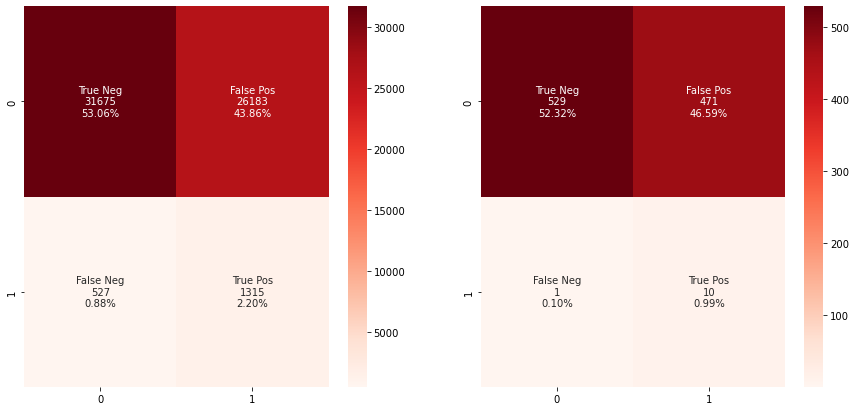

In [96]:
sgd.conf_mat(y_df0,y_future_down)

In [97]:
y_future.value_counts()

0    3542
1      11
Name: label, dtype: int64